In [19]:
import rebound
import reboundx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('paper')

In [34]:
def epic(dtfactor):
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=0.93)
    sim.add(m=4.5*3.e-7, P=0.571/365.25, e=0.01)
    #sim.add(m=41.*3.e-7, P=13.34/365.25, e=0.01)
    sim.move_to_com()
    sim.dt = dtfactor*sim.particles[1].P
    return sim

In [40]:
sim = epic(dtfactor=0.080901699437494756)
sim.integrator = "whfast"
rebx = reboundx.Extras(sim)
gr = rebx.load_force("gr")
gr.params["c"] = 63197.8 # AU/yr
intf = rebx.load_operator("integrate_force")
intf.params['force'] = gr
intf.params['integrator'] = reboundx.integrators["rk4"]
rebx.add_operator(intf, dt_fraction=1., timing="post")

In [41]:
tmax = 1.e5
Nout = 1000
times = np.logspace(0, np.log10(tmax), Nout)*sim.particles[1].P
E0 = rebx.gr_hamiltonian(gr)
Eerr = np.zeros(Nout)
for i, time in enumerate(times):
    sim.integrate(time, exact_finish_time=0)
    E = rebx.gr_hamiltonian(gr)
    Eerr[i] = np.abs((E-E0)/E0)

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


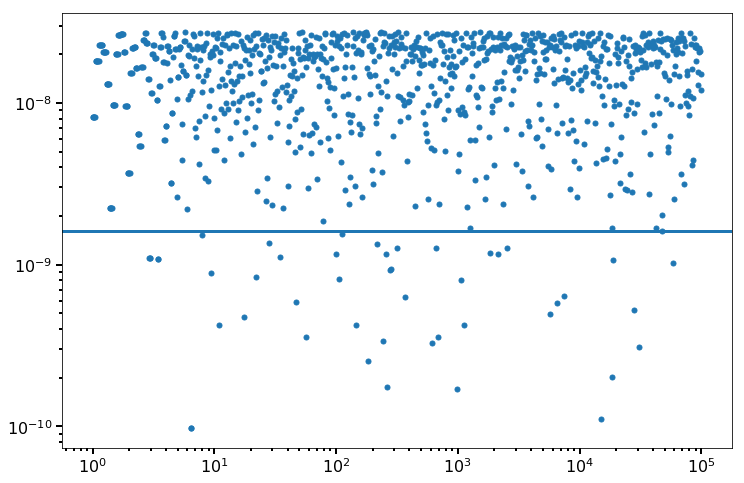

In [42]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times/sim.particles[1].P, Eerr, '.')
ax.axhline(2.e-6*0.080901699437494756*0.01)
ax.set_xscale('log')
ax.set_yscale('log')

In [ ]:
def addGR(sim, rebxintegrator, order, cfac):
    rebx = reboundx.Extras(sim)
    gr = rebx.load_force("gr")
    gr.params["c"] = 63197.8*cfac # AU/yr
    if rebxintegrator != "naive":
        rebx.integrator=rebxintegrator
        gr.operator_order = order 
        gr.force_as_operator = 1
    return rebx

dtfactor = float(sys.argv[1])
integrator = sys.argv[2]
rebxintegrator = sys.argv[3]
tmax = float(sys.argv[4])
order = int(sys.argv[5])
cfac = float(sys.argv[6])
filename = 'data/GRcfac{0}{1}rebx{2}dt{3:.3e}order{4}'.format(cfac, integrator, rebxintegrator, dtfactor, order)

Nout = 10000
sim = epic(dtfactor, integrator)
rebx = addGR(sim, rebxintegrator, order, cfac)
rebx.save(filename+'.rebx')
sim.simulationarchive_snapshot(filename+".sa")

times = np.logspace(0, np.log10(tmax), Nout)*sim.particles[1].P
for i, time in enumerate(times):
    sim.integrate(time, exact_finish_time=0)
    sim.simulationarchive_snapshot(filename+".sa")